# NLP Coursework


## 0. Set-up

### Main imports

In [1]:
!pip install simpletransformers
!pip install tensorboardx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.3 

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from ast import literal_eval
import string
import nltk
from nltk.corpus import stopwords

In [3]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  False


In [4]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

### Fetching the Don't Patronize Me! data manager module

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!wget https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_categories.tsv
!wget https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv

--2024-02-27 22:33:17--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_categories.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1342370 (1.3M) [text/plain]
Saving to: ‘dontpatronizeme_categories.tsv’

dontpatronizeme_cat 100%[===================>]   1.28M  --.-KB/s    in 0.01s   

2024-02-27 22:33:17 (90.1 MB/s) - ‘dontpatronizeme_categories.tsv’ saved [1342370/1342370]

--2024-02-27 22:33:17--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [8]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [9]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
train_df=dpm.train_task1_df
train_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0


## 1. Data analysis of the training data

1.a. Frequency of class labels

In [10]:
num_paragraphs = len(train_df)

category_label_counts = train_df["orig_label"].value_counts().sort_index()
pcl_label_counts = train_df["label"].value_counts().sort_index()

category_label_data = category_label_counts.to_frame(name="Count")
pcl_label_data = pcl_label_counts.to_frame(name="Count")

# Calculate percentages
category_label_data['Percentage'] = ((category_label_counts / category_label_counts.sum()) * 100).round(1)
pcl_label_data['Percentage'] = ((pcl_label_counts / pcl_label_counts.sum()) * 100).round(1)


print(f"Number of paragraphs in train dataset: \n{num_paragraphs}")
print(100*"-")
print("\nPCL Categories:")
print(f"Label 0: both annotators assigned the label 0")
print(f"Label 1: one annotator assigned the label 0 and the other assigned the label 1")
print(f"Label 2: both annotators assigned the label 1")
print(f"Label 3: one annotator assigned the label 2 and the other assigned the label 1")
print(f"Label 4: both annotators assigned the label 2\n")
print(category_label_data)
print(100*"-")
print("\nBinary Labels:")
print(f"Label 0: Number of non-PCL paragraphs (labels 0 and 1 from category labels)")
print(f"Label 1: Number of PCL paragraphs (labels 2, 3 and 4 from category labels)\n")
print(pcl_label_data)
print(100*"-")

# Convert Series to DataFrames
category_label_counts = category_label_counts.reset_index()
pcl_label_counts = pcl_label_counts.reset_index()

Number of paragraphs in train dataset: 
10469
----------------------------------------------------------------------------------------------------

PCL Categories:
Label 0: both annotators assigned the label 0
Label 1: one annotator assigned the label 0 and the other assigned the label 1
Label 2: both annotators assigned the label 1
Label 3: one annotator assigned the label 2 and the other assigned the label 1
Label 4: both annotators assigned the label 2

   Count  Percentage
0   8529        81.5
1    947         9.0
2    144         1.4
3    458         4.4
4    391         3.7
----------------------------------------------------------------------------------------------------

Binary Labels:
Label 0: Number of non-PCL paragraphs (labels 0 and 1 from category labels)
Label 1: Number of PCL paragraphs (labels 2, 3 and 4 from category labels)

   Count  Percentage
0   9476        90.5
1    993         9.5
---------------------------------------------------------------------------------

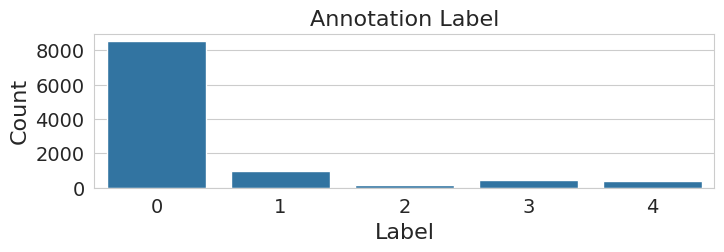

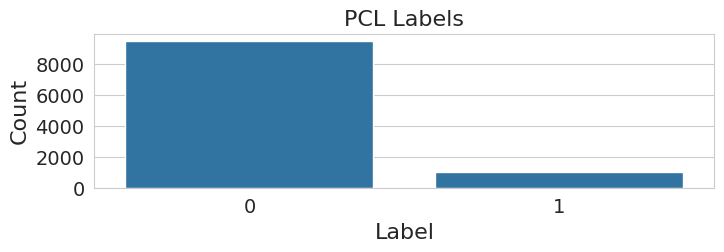

In [11]:
sns.set_style('whitegrid')

# Plotting category labels
plt.figure(figsize=(8, 2))
sns.barplot(x=category_label_counts.index, y="Count", data=category_label_data)
plt.xlabel("Label", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Annotation Label", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Plotting PCL labels
plt.figure(figsize=(8, 2))
sns.barplot(x=pcl_label_counts.index, y="Count", data=pcl_label_data)
plt.xlabel("Label", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("PCL Labels", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

1.1.a Correlation of class labels and data features

1.1.a.i Input lengths

In [12]:
# Input lengths
nltk.download('punkt')
nltk.download('stopwords')
detailed_train_df = train_df.copy()

def calculate_paragraph_length(paragraph):
    return len(paragraph)

def calculate_input_token_count(paragraph):
    tokens = nltk.word_tokenize(paragraph)
    return len(tokens)

def calculate_tokens_without_stopwords_and_punctuation(paragraph):
    tokens = nltk.word_tokenize(paragraph)
    tokens_without_stopwords_and_punctuation = [token for token in tokens if token.lower() not in set(stopwords.words('english')) and token not in string.punctuation]
    return len(tokens_without_stopwords_and_punctuation)

def calculate_length_without_stopwords_and_punctuation(paragraph):
    tokens = nltk.word_tokenize(paragraph)
    tokens_without_stopwords_and_punctuation = [token for token in tokens if token.lower() not in set(stopwords.words('english')) and token not in string.punctuation]
    return len("".join(tokens_without_stopwords_and_punctuation))

def count_punctuation(paragraph):
    return sum(1 for char in paragraph if char in string.punctuation)

detailed_train_df["tokens"] = detailed_train_df["text"].apply(calculate_input_token_count)
detailed_train_df["tokens_no_stp"] = detailed_train_df["text"].apply(calculate_tokens_without_stopwords_and_punctuation)
detailed_train_df["input_length"] = detailed_train_df["text"].apply(calculate_paragraph_length)
detailed_train_df["input_length_no_stp"] = detailed_train_df["text"].apply(calculate_length_without_stopwords_and_punctuation)
detailed_train_df["punctuation_count"] = detailed_train_df["text"].apply(count_punctuation)

detailed_train_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,par_id,art_id,keyword,country,text,label,orig_label,tokens,tokens_no_stp,input_length,input_length_no_stp,punctuation_count
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,123,65,620,360,17
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,41,21,237,140,5
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0,31,23,162,120,7
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,30,18,162,102,2
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0,57,35,277,182,14


In [13]:
print("Mean input length:")
print(detailed_train_df['input_length'].mean().round(1))

print("Mean num tokens:")
print(detailed_train_df['tokens'].mean().round(1))

Mean input length:
267.6
Mean num tokens:
49.7


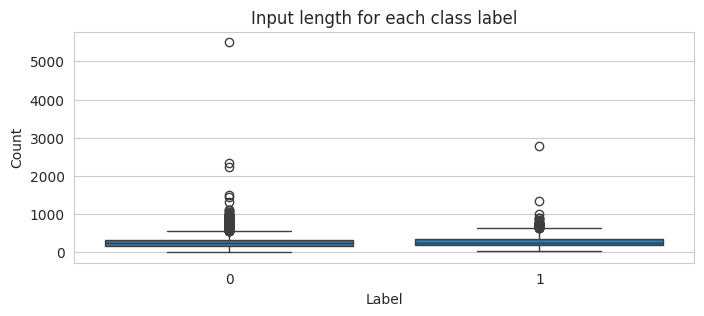

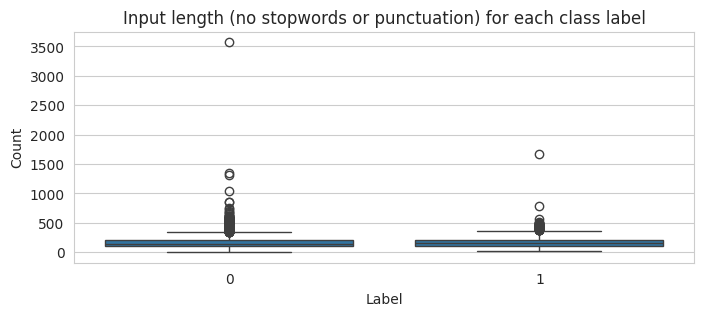

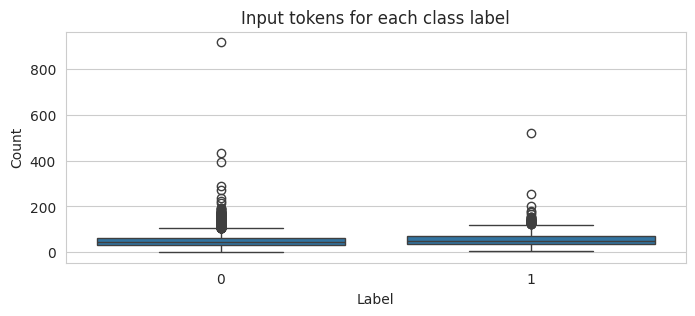

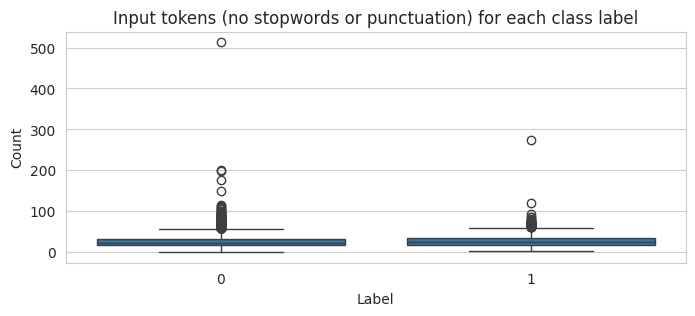

Input tokens statistics:
Mean number of tokens
label
0    49.1
1    55.2
Name: tokens, dtype: float64
Std number of tokens
label
0    29.2
1    33.2
Name: tokens, dtype: float64

Input tokens (no stopwords or punctuation) statistics:
Mean input length
label
0    26.5
1    28.4
Name: tokens_no_stp, dtype: float64
Std input length
label
0    15.4
1    16.8
Name: tokens_no_stp, dtype: float64

Input length statistics:
Mean input length
label
0    265.4
1    288.5
Name: input_length, dtype: float64
Std input length
label
0    158.4
1    175.5
Name: input_length, dtype: float64

Input length (no stopwords or punctuation) statistics:
Mean input length
label
0    164.0
1    170.8
Name: input_length_no_stp, dtype: float64
Std input length
label
0     98.0
1    103.8
Name: input_length_no_stp, dtype: float64


In [14]:
plt.figure(figsize=(8, 3))
sns.boxplot(x="label", y="input_length", data=detailed_train_df)
plt.title("Input length for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="label", y="input_length_no_stp", data=detailed_train_df)
plt.title("Input length (no stopwords or punctuation) for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="label", y="tokens", data=detailed_train_df)
plt.title("Input tokens for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="label", y="tokens_no_stp", data=detailed_train_df)
plt.title("Input tokens (no stopwords or punctuation) for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Input tokens statistics:")
mean_tokens_per_label = detailed_train_df.groupby('label')['tokens'].mean().round(1)
std_tokens_per_label = detailed_train_df.groupby('label')['tokens'].std().round(1)
print("Mean number of tokens")
print(mean_tokens_per_label)
print("Std number of tokens")
print(std_tokens_per_label)

print("\nInput tokens (no stopwords or punctuation) statistics:")
mean_tokens_no_stp_per_label = detailed_train_df.groupby('label')['tokens_no_stp'].mean().round(1)
std_tokens_no_stp_per_label = detailed_train_df.groupby('label')['tokens_no_stp'].std().round(1)
print("Mean input length")
print(mean_tokens_no_stp_per_label)
print("Std input length")
print(std_tokens_no_stp_per_label)

print("\nInput length statistics:")
mean_input_length_per_label = detailed_train_df.groupby('label')['input_length'].mean().round(1)
std_input_length_per_label = detailed_train_df.groupby('label')['input_length'].std().round(1)
print("Mean input length")
print(mean_input_length_per_label)
print("Std input length")
print(std_input_length_per_label)

print("\nInput length (no stopwords or punctuation) statistics:")
mean_no_stp_length_per_label = detailed_train_df.groupby('label')['input_length_no_stp'].mean().round(1)
std_no_stp_length_per_label = detailed_train_df.groupby('label')['input_length_no_stp'].std().round(1)
print("Mean input length")
print(mean_no_stp_length_per_label)
print("Std input length")
print(std_no_stp_length_per_label)

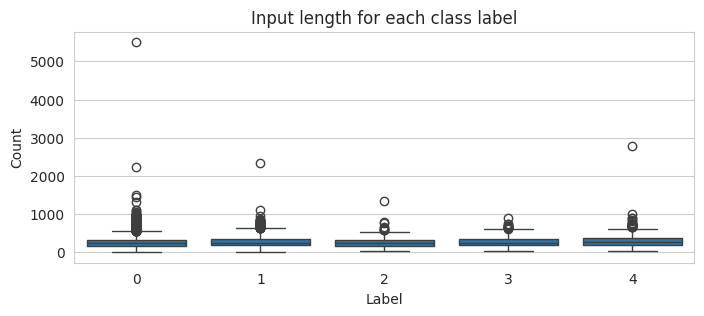

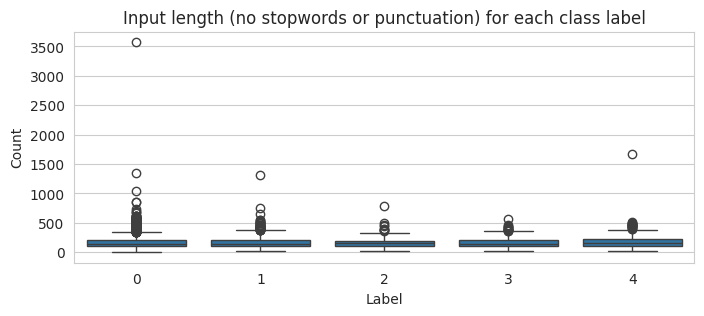

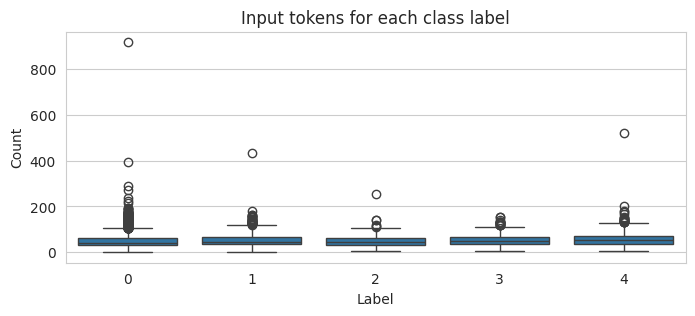

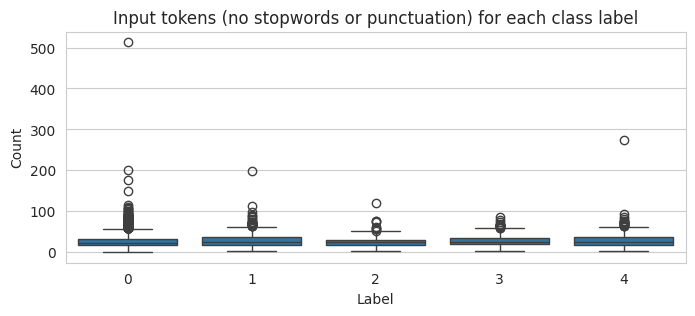

Input tokens statistics:
Mean number of tokens
orig_label
0    48.6
1    53.6
2    50.2
3    53.2
4    59.3
Name: tokens, dtype: float64
Std number of tokens
orig_label
0    28.9
1    31.1
2    31.5
3    26.0
4    40.3
Name: tokens, dtype: float64

Input tokens (no stopwords or punctuation) statistics:
Mean input length
orig_label
0    26.3
1    28.2
2    26.9
3    27.7
4    29.9
Name: tokens_no_stp, dtype: float64
Std input length
orig_label
0    15.3
1    15.9
2    16.1
3    13.4
4    20.2
Name: tokens_no_stp, dtype: float64

Input length statistics:
Mean input length
orig_label
0    263.3
1    284.2
2    270.2
3    278.8
4    306.5
Name: input_length, dtype: float64
Std input length
orig_label
0    157.0
1    168.9
2    171.5
3    138.6
4    211.0
Name: input_length, dtype: float64

Input length (no stopwords or punctuation) statistics:
Mean input length
orig_label
0    163.2
1    171.5
2    165.0
3    166.5
4    177.9
Name: input_length_no_stp, dtype: float64
Std input length
orig_

In [15]:
plt.figure(figsize=(8, 3))
sns.boxplot(x="orig_label", y="input_length", data=detailed_train_df)
plt.title("Input length for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="orig_label", y="input_length_no_stp", data=detailed_train_df)
plt.title("Input length (no stopwords or punctuation) for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="orig_label", y="tokens", data=detailed_train_df)
plt.title("Input tokens for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(x="orig_label", y="tokens_no_stp", data=detailed_train_df)
plt.title("Input tokens (no stopwords or punctuation) for each class label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Input tokens statistics:")
mean_tokens_per_label = detailed_train_df.groupby('orig_label')['tokens'].mean().round(1)
std_tokens_per_label = detailed_train_df.groupby('orig_label')['tokens'].std().round(1)
print("Mean number of tokens")
print(mean_tokens_per_label)
print("Std number of tokens")
print(std_tokens_per_label)

print("\nInput tokens (no stopwords or punctuation) statistics:")
mean_tokens_no_stp_per_label = detailed_train_df.groupby('orig_label')['tokens_no_stp'].mean().round(1)
std_tokens_no_stp_per_label = detailed_train_df.groupby('orig_label')['tokens_no_stp'].std().round(1)
print("Mean input length")
print(mean_tokens_no_stp_per_label)
print("Std input length")
print(std_tokens_no_stp_per_label)

print("\nInput length statistics:")
mean_input_length_per_label = detailed_train_df.groupby('orig_label')['input_length'].mean().round(1)
std_input_length_per_label = detailed_train_df.groupby('orig_label')['input_length'].std().round(1)
print("Mean input length")
print(mean_input_length_per_label)
print("Std input length")
print(std_input_length_per_label)

print("\nInput length (no stopwords or punctuation) statistics:")
mean_no_stp_length_per_label = detailed_train_df.groupby('orig_label')['input_length_no_stp'].mean().round(1)
std_no_stp_length_per_label = detailed_train_df.groupby('orig_label')['input_length_no_stp'].std().round(1)
print("Mean input length")
print(mean_no_stp_length_per_label)
print("Std input length")
print(std_no_stp_length_per_label)

1.1.a.ii Top and unique words

In [16]:
from collections import Counter
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

pcl_word_count_dfs = {}

# Define stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# Iterate over unique labels
for label in detailed_train_df["label"].unique():
    # Filter dataframe for the current label
    label_df = detailed_train_df[detailed_train_df["label"] == label]

    # Concatenate all paragraphs into a single string for the current label
    all_paragraphs = ' '.join(label_df['text'])

    # Remove punctuation and tokenize the string into words
    words = nltk.word_tokenize(re.sub(r'[^\w\s]', '', all_paragraphs))

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords]

    # Count the occurrences of each word
    word_counts = Counter(filtered_words)

    # Create a new dataframe to store unique words and their counts for the current label
    word_count_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])

    # Sort the dataframe by the 'Count' column in descending order
    sorted_word_count_df = word_count_df.sort_values(by='Count', ascending=False)

    # Store the sorted dataframe in the dictionary with the label as the key
    pcl_word_count_dfs[label] = sorted_word_count_df

# Access the dataframe for each label
for label, word_count_df in pcl_word_count_dfs.items():
    print(f"Label: {label}")
    print(word_count_df[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label: 0
           Word  Count
81         said   1964
6        people   1509
291       women   1476
61   immigrants   1237
304    families   1116
851        need   1102
282  vulnerable   1100
98     disabled   1009
303        poor    929
87         also    878
Label: 1
         Word  Count
118    people    243
154      need    238
197      poor    231
198  families    212
1        said    192
75   children    189
62   homeless    173
36       help    134
161     women    134
16   disabled    102


In [17]:
category_word_count_dfs = {}

# Define stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# Iterate over unique labels
for label in detailed_train_df["orig_label"].unique():
    # Filter dataframe for the current label
    label_df = detailed_train_df[detailed_train_df["orig_label"] == label]

    # Concatenate all paragraphs into a single string for the current label
    all_paragraphs = ' '.join(label_df["text"])

    # Remove punctuation and tokenize the string into words
    words = nltk.word_tokenize(re.sub(r'[^\w\s]', '', all_paragraphs))

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords]

    # Count the occurrences of each word
    word_counts = Counter(filtered_words)

    # Create a new dataframe to store unique words and their counts for the current label
    word_count_df = pd.DataFrame(list(word_counts.items()), columns=["Word", "Count"])

    # Sort the dataframe by the 'Count' column in descending order
    sorted_word_count_df = word_count_df.sort_values(by='Count', ascending=False)

    # Store the sorted dataframe in the dictionary with the label as the key
    category_word_count_dfs[label] = sorted_word_count_df

# Access the dataframe for each label
for label, word_count_df in category_word_count_dfs.items():
    print(f"Label: {label}")
    print(word_count_df[:10])

Label: 0
           Word  Count
81         said   1726
278       women   1324
6        people   1263
61   immigrants   1182
269  vulnerable   1010
753        need    948
291    families    920
98     disabled    904
87         also    790
290        poor    755
Label: 1
         Word  Count
102    people    246
10       said    238
211  families    196
210      poor    174
300      need    154
215     women    152
6    homeless    139
133  children    122
131  disabled    105
243      help     94
Label: 2
         Word  Count
181  families     37
44     people     35
180      poor     32
177  children     30
243      need     27
1        said     25
394  homeless     25
64      women     24
16   disabled     22
168      help     19
Label: 3
           Word  Count
200        need    108
131    families    104
98       people     98
120        said     98
130        poor     97
55     children     78
42     homeless     75
16         help     68
269       women     59
301  vulnerable    

In [18]:
# Initialize lists to store top 10 words for each label
top_words_per_pcl_label = {}

for label, word_count_df in pcl_word_count_dfs.items():
    # Get the top 10 words for the current label
    top_words = list(word_count_df.head(20)['Word'])
    top_words_per_pcl_label[label] = set(top_words)

# Initialize a set to store words that are present in the top 10 for each label
common_words = set(top_words_per_pcl_label[next(iter(top_words_per_pcl_label))])

# Iterate over top_words_per_label and find the intersection of top 10 words for each label
for label, top_words in top_words_per_pcl_label.items():
    common_words = common_words.intersection(top_words)

# Initialize a dictionary to store words that are unique to each label
unique_words_per_label = {label: [] for label in top_words_per_pcl_label.keys()}

# Iterate over top_words_per_label and find words unique to each label
for label, top_words in top_words_per_pcl_label.items():
    unique_words = top_words.difference(common_words)
    unique_words_per_label[label] = list(unique_words)

# Print the list of words that are present in the top 10 for each label but not in the top 10 of the other labels
for label, unique_words in unique_words_per_label.items():
    print(f"Words unique to {label}: {unique_words}")

Words unique to 0: ['one', 'immigrants', 'government', 'year']
Words unique to 1: ['us', 'help', 'hopeless', 'life']


In [19]:
from itertools import combinations

# Initialize lists to store top 25 words for each label
top_words_per_category_label = {}

# Iterate over dataframes for each label
for label, word_count_df in category_word_count_dfs.items():
    # Get the top 25 words for the current label
    top_words = list(word_count_df.head(25)['Word'])
    top_words_per_category_label[label] = set(top_words)

# Initialize a set to store words that are present in the top 25 for each label
common_words = set()
for label1, label2 in combinations(top_words_per_category_label.keys(), 2):
    common_words.update(top_words_per_category_label[label1].intersection(top_words_per_category_label[label2]))

# Initialize a dictionary to store words that are unique to each label
unique_words_per_label = {label: [] for label in top_words_per_category_label.keys()}

# Iterate over top_words_per_category_label and find words unique to each label
for label, top_words in top_words_per_category_label.items():
    unique_words = top_words.difference(common_words)
    unique_words_per_label[label] = list(unique_words)

# Print the list of words that are present in the top 10 for each label but not in the top 20 of the other labels
for label, unique_words in unique_words_per_label.items():
    print(f"Words unique to {label}: {unique_words}")

Words unique to 0: ['refugee', 'illegal', 'US', 'year']
Words unique to 1: ['hopelessness']
Words unique to 2: ['work', 'child', 'blood', 'could']
Words unique to 3: ['poverty']
Words unique to 4: ['us', 'give', 'like', 'hope']


1.1.a.iii Correlations

In [20]:
detailed_train_df['orig_label'] = detailed_train_df['orig_label'].astype(int)

correlation_pcl_tokens = detailed_train_df['label'].corr(detailed_train_df['tokens'])
correlation_class_tokens = detailed_train_df['orig_label'].corr(detailed_train_df['tokens'])

correlation_pcl_tokens_no_stp = detailed_train_df['label'].corr(detailed_train_df['tokens_no_stp'])
correlation_class_tokens_no_stp = detailed_train_df['orig_label'].corr(detailed_train_df['tokens_no_stp'])

correlation_pcl_input_length = detailed_train_df['label'].corr(detailed_train_df['input_length'])
correlation_class_input_length = detailed_train_df['orig_label'].corr(detailed_train_df['input_length'])

correlation_pcl_input_no_stp_length = detailed_train_df['label'].corr(detailed_train_df['input_length_no_stp'])
correlation_class_input_no_stp_length = detailed_train_df['orig_label'].corr(detailed_train_df['input_length_no_stp'])

correlation_pcl_punctuation_count = detailed_train_df['label'].corr(detailed_train_df['punctuation_count'])
correlation_class_punctuation_count = detailed_train_df['orig_label'].corr(detailed_train_df['punctuation_count'])

print("Input tokens correlation:")
print("Correlation PCL:", correlation_pcl_tokens)
print("Correlation Class:", correlation_class_tokens)

print("\nInput tokens without stopwords or punctuation correlation:")
print("Correlation PCL:", correlation_pcl_tokens_no_stp)
print("Correlation Class:", correlation_class_tokens_no_stp)

print("\nInput length correlation:")
print("Correlation PCL:", correlation_pcl_input_length)
print("Correlation Class:", correlation_class_input_length)

print("\nInput without stopwords or punctuation length correlation:")
print("Correlation PCL:", correlation_pcl_input_no_stp_length)
print("Correlation Class:", correlation_class_input_no_stp_length)

print("\nInput punctuation correlation:")
print("Correlation PCL:", correlation_pcl_punctuation_count)
print("Correlation Class:", correlation_class_punctuation_count)

Input tokens correlation:
Correlation PCL: 0.05989354813509501
Correlation Class: 0.0773290751496345

Input tokens without stopwords or punctuation correlation:
Correlation PCL: 0.036210432966341
Correlation Class: 0.048477675730512974

Input length correlation:
Correlation PCL: 0.04217396329356937
Correlation Class: 0.055940204030604526

Input without stopwords or punctuation length correlation:
Correlation PCL: 0.020054663877964826
Correlation Class: 0.029174234315588174

Input punctuation correlation:
Correlation PCL: 0.038832333312799866
Correlation Class: 0.055750662634088566


1.1.a.iv Label and keyword relationship

In [21]:
pcl_label_counts = detailed_train_df['label'].value_counts()

# Group by label and keyword, then count occurrences
pcl_grouped_counts = detailed_train_df.groupby(['keyword', 'label']).size()

# Calculate the frequency for each keyword and label
pcl_frequency_per_keyword = 100 * pcl_grouped_counts / pcl_grouped_counts.groupby(level=0).sum()


print(pcl_frequency_per_keyword.swaplevel().sort_index().sort_values(ascending=False))

label  keyword      
0      immigrant        97.172479
       migrant          96.694215
       women            95.140187
       vulnerable       92.592593
       disabled         92.120623
       refugee          91.947566
       hopeless         87.661692
       in-need          83.733826
       poor-families    83.498350
       homeless         83.472609
1      homeless         16.527391
       poor-families    16.501650
       in-need          16.266174
       hopeless         12.338308
       refugee           8.052434
       disabled          7.879377
       vulnerable        7.407407
       women             4.859813
       migrant           3.305785
       immigrant         2.827521
dtype: float64


1.1.a.v Label and country relationship

In [22]:
# Group by label and keyword, then count occurrences
pcl_grouped_counts = detailed_train_df.groupby(['country', 'label']).size()
pcl_frequency_per_country = 100*pcl_grouped_counts / pcl_grouped_counts.groupby(level=0).sum()

print(pcl_frequency_per_country.swaplevel().sort_index().sort_values(ascending=False))

label  country
0      hk         94.081633
       au         93.160813
       sg         92.897196
       in         92.641509
       my         92.124542
       us         91.896869
       ke         91.651206
       bd         91.406250
       ca         91.320755
       nz         90.926641
       ie         90.316574
       lk         90.277778
       pk         90.275229
       tz         90.120482
       gb         89.444444
       za         89.435337
       jm         88.367347
       ph         87.706422
       ng         86.592179
       gh         85.659656
1      gh         14.340344
       ng         13.407821
       ph         12.293578
       jm         11.632653
       za         10.564663
       gb         10.555556
       tz          9.879518
       pk          9.724771
       lk          9.722222
       ie          9.683426
       nz          9.073359
       ca          8.679245
       bd          8.593750
       ke          8.348794
       us          8.103131
     

1.b. Qualitative Assessment of the dataset

In [23]:
print(train_df[train_df["orig_label"] == "0"]["text"].iloc[0])
print(train_df[train_df["orig_label"] == "1"]["text"].iloc[0])
print(train_df[train_df["orig_label"] == "2"]["text"].iloc[0])
print(train_df[train_df["orig_label"] == "3"]["text"].iloc[0])
print(train_df[train_df["orig_label"] == "4"]["text"].iloc[0])

We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .
NUEVA ERA , Ilocos Norte - No family shall be homeless under the watch of the municipal government here , said town Mayor Aldrin Garvida .
Arshad said that besides learning many new aspects of sports leadership he learnt how fast-developing nations were using sports as a tool of development and in this effort the disabled and the underprivileged were not left behind at any sta